In [19]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import scipy
import scipy.misc as misc
import tensorflow as tf
import os, pickle
import matplotlib.pyplot as plt

from nets import nets_factory
from preprocessing import preprocessing_factory
import numpy as np
import cv2


slim = tf.contrib.slim
checkpoint_path = "/home/ttdat/data/model/traffic"
model_name = "densenet169"
pickle_path = "/home/ttdat/data/Dataset/Traffic/features_labels.pkl"
image_dir = "/home/ttdat/data/Dataset/Traffic/Images"

In [2]:
def load_graph(sess):
    eval_image_size = 224

    input_shape = (eval_image_size, eval_image_size, 3)
    image_X = tf.placeholder(dtype=tf.float32) #, shape=input_shape)

    preprocessing_name = "densenet169"
    image_preprocessing_fn = preprocessing_factory.get_preprocessing(
      preprocessing_name,
      is_training=False)

    image = image_preprocessing_fn(image_X, eval_image_size, eval_image_size)
    images = tf.expand_dims(image, axis=[0])

    network_fn = nets_factory.get_network_fn(
      model_name,
      num_classes=3,
      is_training=False)

    logits, end_points = network_fn(images)
    logits = tf.squeeze(logits, (1, 2))
    variables_to_restore = slim.get_variables_to_restore()

    predictions = tf.argmax(logits, 1)

    saver = tf.train.Saver(variables_to_restore)

    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_path))

    return end_points, image_X, predictions

In [17]:
def predict(image_path, image_X, predictions, conv):
    input_image = scipy.misc.imread(image_path)
    class_id, top_conv = sess.run([predictions, conv], feed_dict={image_X: input_image})
    return top_conv, class_id[0]

In [9]:
def get_activation_map(conv, classes_idx, weights, image_size = 224):
    batch_size, height, width, channel = conv.shape
    assert batch_size == 1, "Activation map supports for 1 image"
    conv_reshape = conv.reshape((height * width, channel))
    output = []
    cam = weights[0, 0, :, classes_idx].dot(conv_reshape.T)
    cam = cam.T.reshape((height, width))
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    output = cv2.resize(cam_img, (image_size, image_size))
    return output

In [4]:
sess = tf.Session()
end_points, image_X, predictions = load_graph(sess)

INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from /home/ttdat/data/model/traffic/model.ckpt-19099


In [15]:
conv = end_points['densenet169/dense_block4']
logit_weigths = sess.run(slim.get_variables("densenet169/logits/weights")[0])

/home/ttdat/virtualenv/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/home/ttdat/virtualenv/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


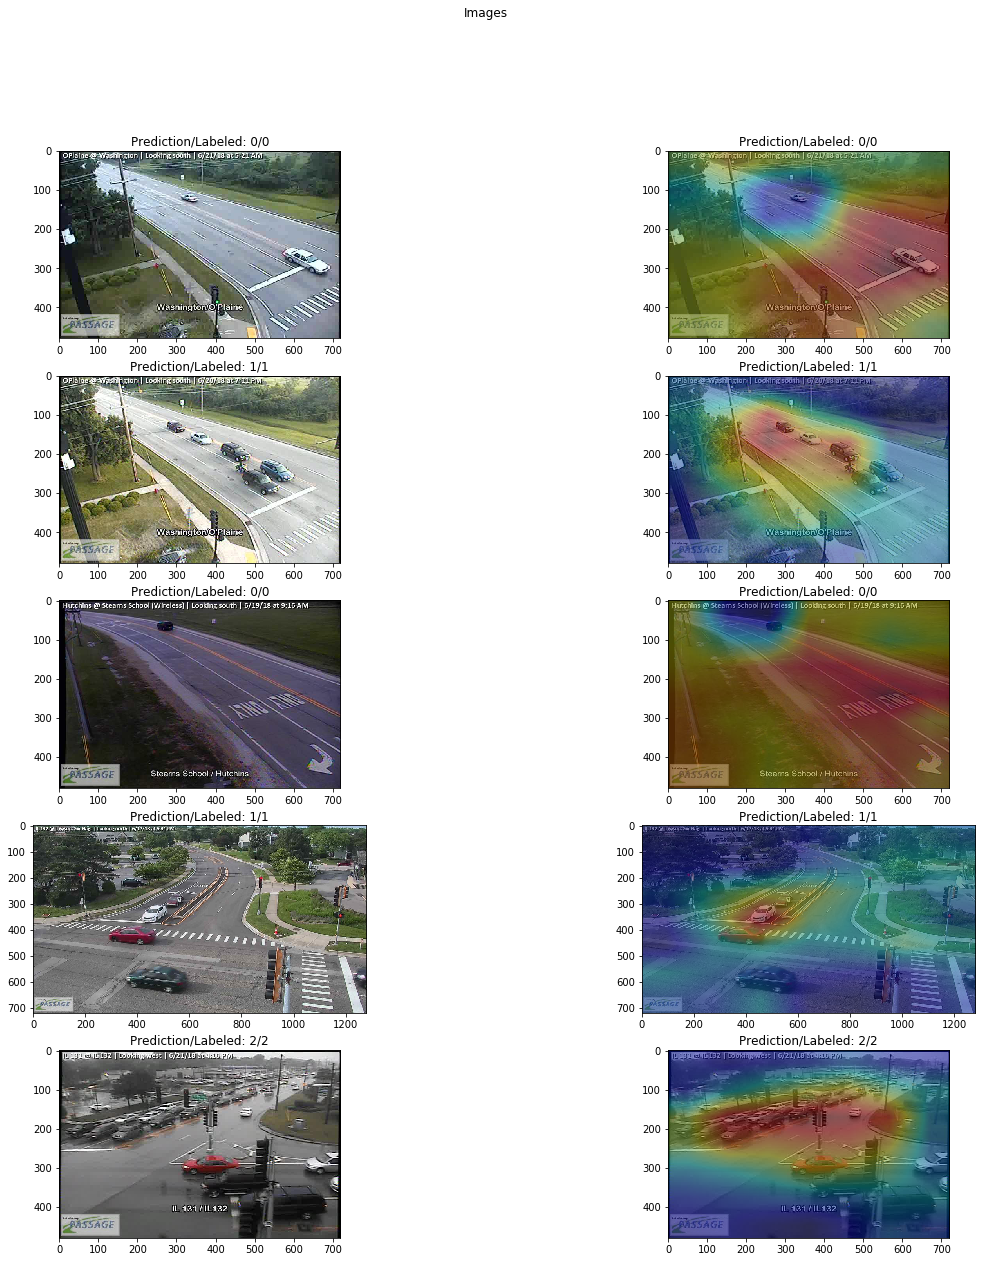

In [22]:
Nr = 5
Nc = 2
fig, axs = plt.subplots(Nr, Nc, figsize=(20, 20))
fig.suptitle('Images')

dictionary = pickle.load(open(pickle_path, "rb"))
images_list = np.random.choice(dictionary.keys(), 5, False)
for i, image_name in enumerate(images_list):
    image_path = os.path.join(image_dir, image_name)
    image = scipy.misc.imread(image_path)
    axs[i, 0].imshow(image)
    
    top_conv, class_id = predict(image_path, image_X, predictions, conv)
    label_id = dictionary[image_name][1]
    
    activation_map = get_activation_map(top_conv, class_id, logit_weigths)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    height, width, _ = image.shape
    heatmap = cv2.applyColorMap(cv2.resize(activation_map,(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + image * 0.5
    result = cv2.cvtColor(result.astype(np.uint8), cv2.COLOR_BGR2RGB)
    
    axs[i, 1].imshow(result)
    axs[i, 0].set_title("Prediction/Labeled: %d/%d" % (class_id, label_id))
    axs[i, 1].set_title("Prediction/Labeled: %d/%d" % (class_id, label_id))
    